<a href="https://colab.research.google.com/github/yahui624/CVFinalProject/blob/main/StableDiffusion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
!pip install diffusers 
!pip install transformers scipy ftfy
!pip install "ipywidgets>=7,<8"
!pip install accelerate

In [15]:
import os 
from PIL import Image, ImageDraw, ImageShow
import cv2
import numpy as np
from IPython.display import HTML
from base64 import b64encode

import torch
from torch import autocast 
from torch.nn import functional as F 
from diffusers import StableDiffusionPipeline, AutoencoderKL, UNet2DConditionModel, PNDMScheduler, LMSDiscreteScheduler
from diffusers.schedulers.scheduling_ddim import DDIMScheduler 
from transformers import CLIPTextModel, CLIPTokenizer 
from tqdm.auto import tqdm
from huggingface_hub import notebook_login
from google.colab import output 

device ='cuda'
output.enable_custom_widget_manager()
notebook_login()

Token is valid.
Your token has been saved in your configured git credential helpers (store).
Your token has been saved to /root/.huggingface/token
Login successful


In [4]:
pipe = StableDiffusionPipeline.from_pretrained('CompVis/stable-diffusion-v1-4', revision='fp16', torch_dtype = torch.float16, use_auth_token=True)
pipe = pipe.to(device)

Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.


Downloading:   0%|          | 0.00/543 [00:00<?, ?B/s]

Fetching 16 files:   0%|          | 0/16 [00:00<?, ?it/s]

Downloading:   0%|          | 0.00/342 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/4.63k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/608M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/209 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/209 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/572 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/246M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/525k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/472 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/788 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/772 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.72G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/550 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/167M [00:00<?, ?B/s]

/usr/local/lib/python3.7/dist-packages/diffusers/utils/deprecation_utils.py:35: FutureWarning: The configuration file of this scheduler: PNDMScheduler {
  "_class_name": "PNDMScheduler",
  "_diffusers_version": "0.9.0",
  "beta_end": 0.012,
  "beta_schedule": "scaled_linear",
  "beta_start": 0.00085,
  "num_train_timesteps": 1000,
  "set_alpha_to_one": false,
  "skip_prk_steps": true,
  "steps_offset": 0,
  "trained_betas": null
}
 is outdated. `steps_offset` should be set to 1 instead of 0. Please make sure to update the config accordingly as leaving `steps_offset` might led to incorrect results in future versions. If you have downloaded this checkpoint from the Hugging Face Hub, it would be very nice if you could open a Pull request for the `scheduler/scheduler_config.json` file
  warnings.warn(warning + message, FutureWarning)


In [17]:
prompt = 'cute japanese akita dog'
with autocast (device):
  images = pipe(prompt).images
images[0].save("hoshi.png")

  0%|          | 0/51 [00:00<?, ?it/s]

In [18]:
def image_grid(imgs, rows, cols):
    assert len(imgs) == rows*cols

    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    grid_w, grid_h = grid.size
    
    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

  0%|          | 0/51 [00:00<?, ?it/s]

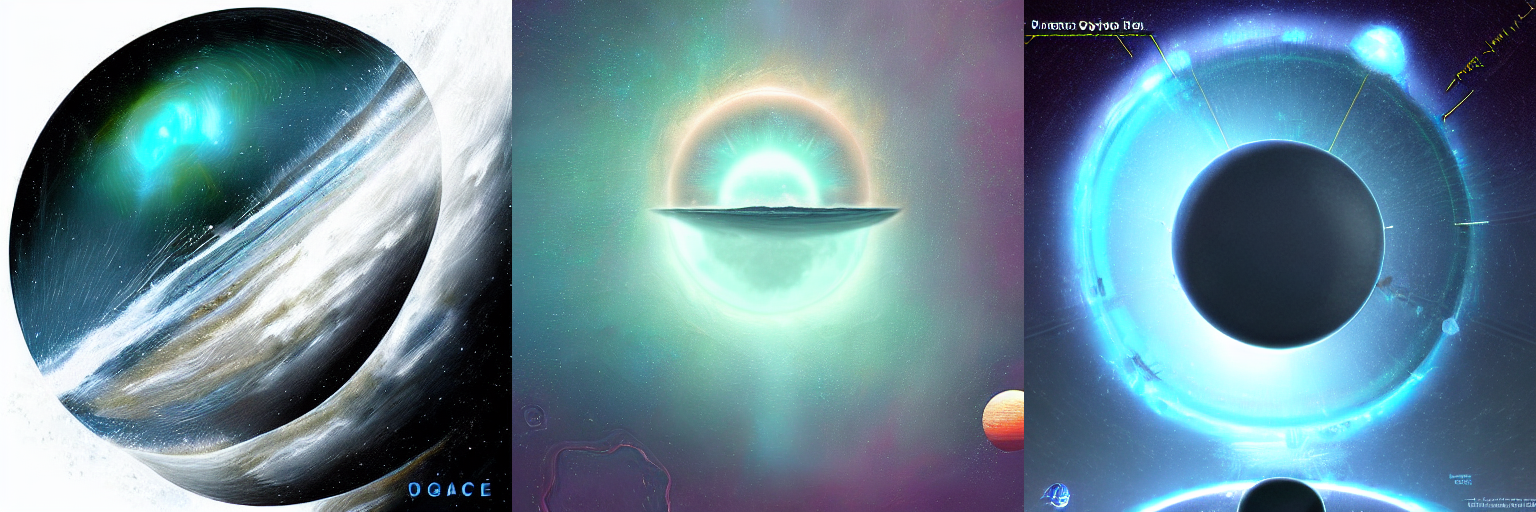

In [20]:
n_images = 3
prompts = ['Planet scale halo of water in space digital art, Trending on ArtStation'] * n_images
with autocast(device):
  images = pipe(prompts, num_inference_steps=50).images
image_grid(images, rows=1, cols=3)

**Custom Stable Diffision pipeline**

In [22]:
# 1. load the autoencoder model which will be used to decode the latents into image space 
vae = AutoencoderKL.from_pretrained('CompVis/stable-diffusion-v1-4', subfolder='vae', use_auth_token=True)
vae = vae.to(device)

Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.


Downloading:   0%|          | 0.00/335M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/522 [00:00<?, ?B/s]

In [23]:
# 2. load the tokenizer and text encoder to tokenzie and encode the text 
tokenizer = CLIPTokenizer.from_pretrained('openai/clip-vit-large-patch14')
text_encoder = CLIPTextModel.from_pretrained('openai/clip-vit-large-patch14').to(device)

Downloading:   0%|          | 0.00/961k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/525k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/389 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/905 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/4.52k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.71G [00:00<?, ?B/s]

Some weights of the model checkpoint at openai/clip-vit-large-patch14 were not used when initializing CLIPTextModel: ['vision_model.encoder.layers.3.self_attn.out_proj.bias', 'vision_model.encoder.layers.10.layer_norm2.bias', 'vision_model.encoder.layers.19.self_attn.v_proj.weight', 'vision_model.encoder.layers.10.self_attn.out_proj.weight', 'vision_model.encoder.layers.12.self_attn.k_proj.bias', 'vision_model.encoder.layers.2.self_attn.v_proj.bias', 'vision_model.encoder.layers.3.layer_norm1.weight', 'vision_model.encoder.layers.22.self_attn.k_proj.bias', 'vision_model.encoder.layers.1.self_attn.q_proj.weight', 'vision_model.encoder.layers.4.layer_norm1.weight', 'vision_model.encoder.layers.3.layer_norm2.bias', 'vision_model.encoder.layers.7.layer_norm2.bias', 'vision_model.encoder.layers.22.self_attn.q_proj.bias', 'vision_model.embeddings.position_ids', 'vision_model.encoder.layers.20.layer_norm1.weight', 'vision_model.encoder.layers.9.mlp.fc1.weight', 'vision_model.encoder.layers.19

In [24]:
# 3. UNet model for generating the latents 
unet = UNet2DConditionModel.from_pretrained('CompVis/stable-diffusion-v1-4', subfolder='unet', use_auth_token=True).to(device)

Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.


Downloading:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/743 [00:00<?, ?B/s]

In [26]:
# 4. Create a scheduler for inference 
scheduler = LMSDiscreteScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule='scaled_linear', num_train_timesteps=1000)

In [31]:
def get_text_embeds(prompt): 
  # Tokenize text and get embeddings 
  text_input = tokenizer(prompt, padding='max_length', max_length=tokenizer.model_max_length, truncation=True, return_tensors='pt')
  with torch.no_grad():
    text_embeddings = text_encoder(text_input.input_ids.to(device))[0]

  uncondi_input = tokenizer(['']*len(prompt), padding='max_length', max_length=tokenizer.model_max_length, return_tensors='pt')
  with torch.no_grad(): 
    uncondi_embeddings = text_encoder(uncondi_input.input_ids.to(device))[0]

  # concat final embeddings 
  text_embeddings = torch.cat([uncondi_embeddings, text_embeddings])
  return text_embeddings 

In [32]:
test_embeddings = get_text_embeds(['cute japanese akita dog'])
print(test_embeddings)
print(test_embeddings.shape)

tensor([[[-0.3884,  0.0229, -0.0522,  ..., -0.4899, -0.3066,  0.0675],
         [-0.3711, -1.4497, -0.3401,  ...,  0.9489,  0.1867, -1.1034],
         [-0.5107, -1.4629, -0.2926,  ...,  1.0419,  0.0701, -1.0284],
         ...,
         [ 0.5006, -0.9552, -0.6610,  ...,  1.6013, -1.0622, -0.2191],
         [ 0.4988, -0.9451, -0.6656,  ...,  1.6467, -1.0858, -0.2088],
         [ 0.4923, -0.8124, -0.4912,  ...,  1.6108, -1.0174, -0.2484]],

        [[-0.3884,  0.0229, -0.0522,  ..., -0.4899, -0.3066,  0.0675],
         [-0.4771, -0.4680,  0.0514,  ..., -0.1052, -0.4885,  0.0188],
         [ 0.3470, -0.1976,  0.4000,  ...,  1.9267, -0.5571, -0.1713],
         ...,
         [-1.3478,  1.1169, -1.6063,  ...,  1.4155, -2.0809, -2.0979],
         [-1.3395,  1.0941, -1.5972,  ...,  1.4128, -2.0713, -2.0936],
         [-1.3102,  1.1013, -1.4970,  ...,  1.4125, -2.0697, -2.1242]]],
       device='cuda:0')
torch.Size([2, 77, 768])


In [33]:
def produce_latents(text_embeddings, height=512, width=512, num_inference_steps=50, guidance_scale=7.5, latents=None):
  if latents is None: 
    latents = torch.randn((text_embeddings.shape[0]//2, unet.in_channels, height//8, width//8))

  latents = latents.to(device)
  
  scheduler.set_timesteps(num_inference_steps)
  latents = latents * scheduler.sigmas[0]

  with autocast('cuda'): 
    for i, t in tqdm(enumerate(scheduler.timesteps)): 
      # expand the latents if we are dong classifer-free guidance to avoid doing 2 forward passes 
      latent_model_input = torch.cat([latents] * 2)
      sigmas = scheduler.sigmas[i]
      latent_model_input = latent_model_input/((sigmas**2 + 1) ** 0.5)

      # predict the noise residual 
      with torch.no_grad(): 
        noise_pred = unet(latent_model_input, t, encoder_hidden_states = text_embeddings)['sample']
      
      # perform guidance 
      noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
      noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

      # compute the prev noisy sample x_t -> x_t-1 
      latents = scheduler.step(noise_pred, i, latents)['prev_sample']
  return latents 

In [34]:
test_latents = produce_latents(test_embeddings)

0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/diffusers/schedulers/scheduling_lms_discrete.py:207: UserWarning: The `scale_model_input` function should be called before `step` to ensure correct denoising. See `StableDiffusionPipeline` for a usage example.
  "The `scale_model_input` function should be called before `step` to ensure correct denoising. "


ValueError: ignored